# Machine Learning Assignment 3

#### We imported all the libraries needed...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,label_binarize
from itertools import cycle
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc,confusion_matrix
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Data Preprocessing:
#### Read the data to start working...
#### Display data..¶

In [2]:
data = pd.read_csv('IRIS.csv')
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Data Cleaning...
#### We will check the null values.
The data doen't contain null values.

In [3]:
data.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

#### We will check duplicated values.

In [4]:
print(data.duplicated().sum())

3


#### We dropped the duplicated values.

In [5]:
data.drop_duplicates(inplace=True)

#### Check the duplicated values again, it will be all zeroes.

In [6]:
print(data.duplicated().sum())

0


#### We used box plots to visualize outliers in the 'sepal_width' column.

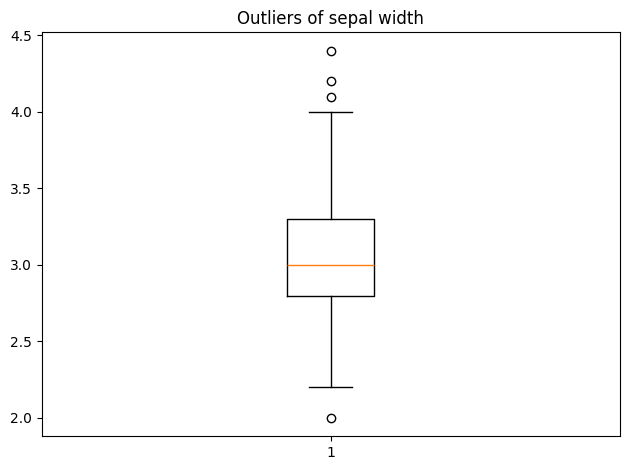

In [7]:
plt.boxplot(x=data['sepal_width'])
plt.title("Outliers of sepal width")
plt.tight_layout()
plt.show()

#### We removed outliers from the 'sepal_width' column using the Interquartile Range (IQR) method.

In [8]:
Q1_sepal_width = data['sepal_width'].quantile(0.25)
Q3_sepal_width = data['sepal_width'].quantile(0.75)
IQR_sepal_width = Q3_sepal_width - Q1_sepal_width
lower_sepal_width = Q1_sepal_width - 1.5 * IQR_sepal_width
upper_sepal_width = Q3_sepal_width + 1.5 * IQR_sepal_width
data_clean = data[
    (data['sepal_width'] >= lower_sepal_width) & (data['sepal_width'] <= upper_sepal_width) ]

#### Finally, We created a boxplot of 'sepal_width' after outlier removal to see its distribution without extreme values.

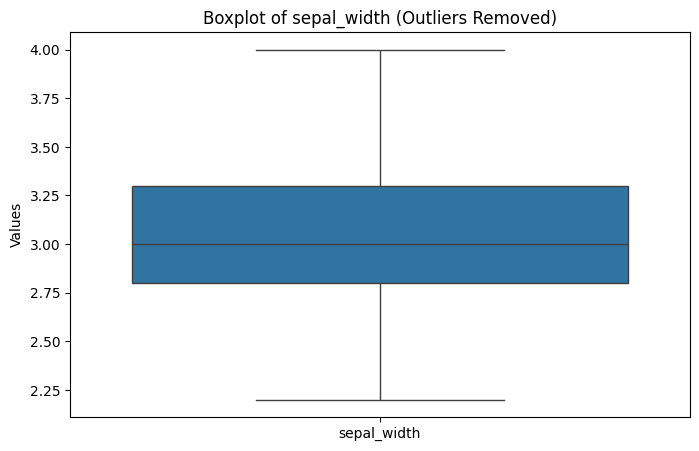

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data_clean[['sepal_width']])
plt.title("Boxplot of sepal_width (Outliers Removed)")
plt.ylabel("Values")
plt.show()

#### We displayed the data after cleaning.

In [10]:
data_clean.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### And this is the final info and discription of data.

In [11]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  143 non-null    float64
 1   sepal_width   143 non-null    float64
 2   petal_length  143 non-null    float64
 3   petal_width   143 non-null    float64
 4   species       143 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.7+ KB


In [12]:
data_clean.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,143.000000,143.000000,143.000000,143.000000
mean,5.870629,3.038462,3.830769,1.230769
std,0.835045,0.398222,1.750824,0.754538
min,4.300000,2.200000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.000000,6.900000,2.500000


### Encoding:
We used LabelEncoder to convert the 'species' column into integer labels for the model. The features are stored in X, and the target labels are in y. Additionally, one-hot encoding is applied to 'species' using to_categorical() for neural network compatibility.

In [13]:
# Encode class labels
label_encoder = LabelEncoder()
data_clean['species'] = label_encoder.fit_transform(data_clean['species'])
X = data_clean.drop('species', axis=1)
y = data['species']  # integer labels for SVM
y_oh = to_categorical(data_clean['species'])  # One-hot encoding

C:\Users\Lap-Top\AppData\Local\Temp\ipykernel_6072\1007302862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['species'] = label_encoder.fit_transform(data_clean['species'])


### Data Splitting:
Split the dataset into training and testing sets(70/30), then convert the one-hot encoded labels back to integer labels for SVM using 'np.argmax()'.

In [14]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.3, random_state=42)

# For SVM, convert y back to 1D integer labels
y_train_s = np.argmax(y_train, axis=1)
y_test_s = np.argmax(y_test, axis=1)

### Standardization of features:
We standardized the features by scaling them to have a mean of 0 and a standard deviation of 1 using StandardScaler. It applies this to both the training and test sets.

In [15]:
# Standardize the features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

### Exploratory Data Analysis (EDA):
#### 1. Correlation Matrics:
Calculate the correlation matrix of the numeric columns (integers and floats) in the data. This matrix shows how strongly each feature is related to the others.

In [16]:
corr_matrix = data_clean.select_dtypes(include=['int64', 'float64']).corr()
corr_matrix

,sepal_length,sepal_width,petal_length,petal_width,species
sepal_length,1.000000,-0.113268,0.879015,0.821715,0.788414
sepal_width,-0.113268,1.000000,-0.396539,-0.328102,-0.394815
petal_length,0.879015,-0.396539,1.000000,0.960785,0.946668
petal_width,0.821715,-0.328102,0.960785,1.000000,0.954711
species,0.788414,-0.394815,0.946668,0.954711,1.000000


#### Then, plot a heatmap of the correlation matrix, showing relationships between numeric features.

<function matplotlib.pyplot.show(close=None, block=None)>

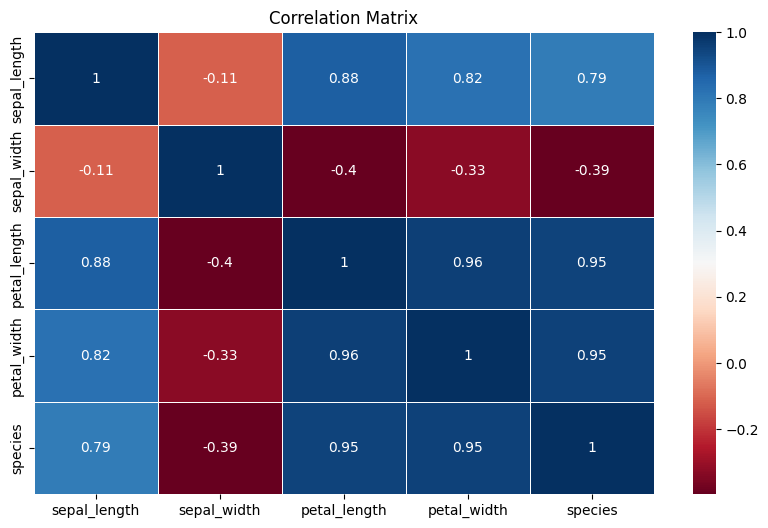

In [17]:
# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data_clean.corr(), annot=True, cmap="RdBu", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show

#### 2. Count Plot:
This plot visualizes the distribution of the target variable 'species' in the data. 

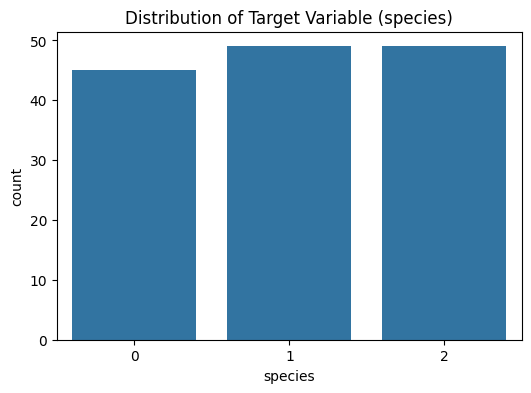

In [18]:
# Check the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='species', data=data_clean)
plt.title('Distribution of Target Variable (species)')
plt.show()

#### 3. Pair Plot:
And this is a pair plot to visualize the relationships between features, colored by the 'species' variable.

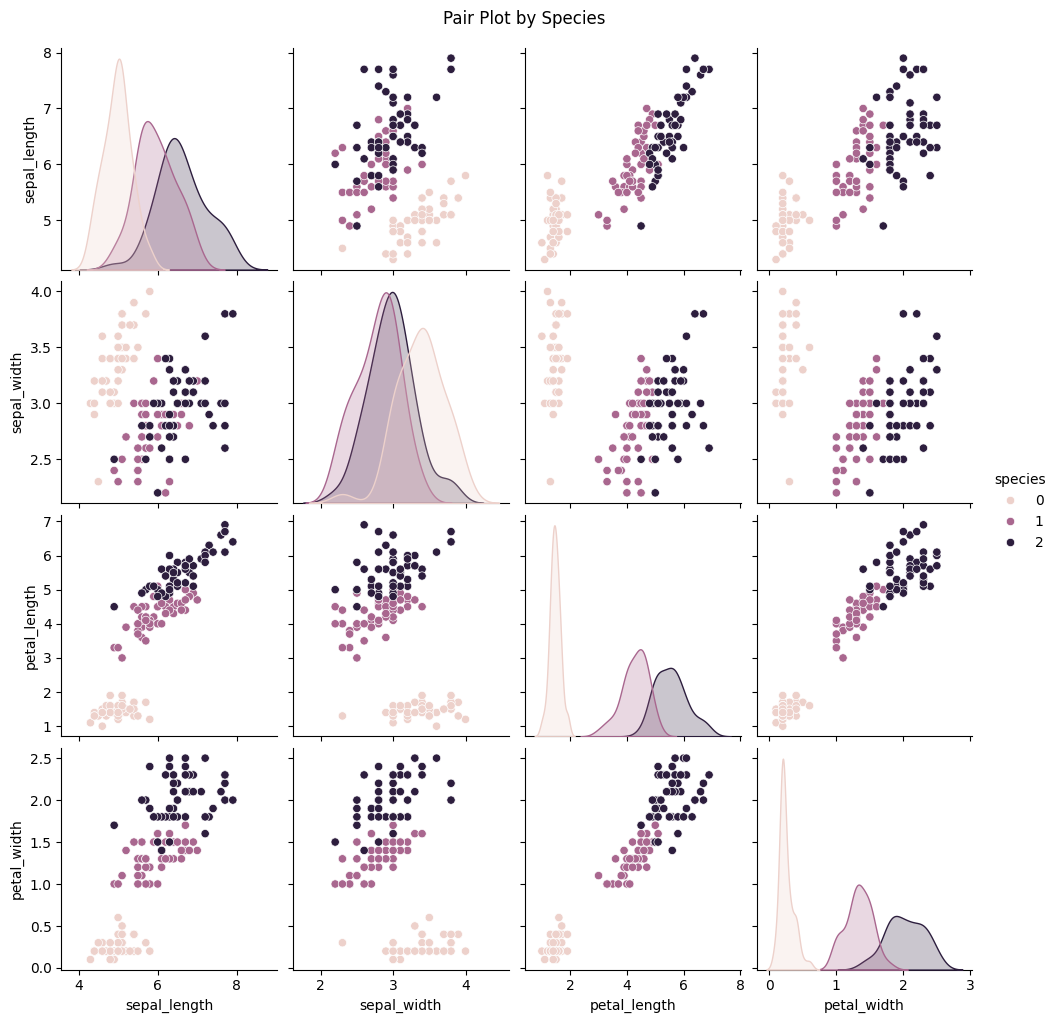

In [19]:
# Pair plot with color by 'species'
sns.pairplot(data_clean, hue='species')
plt.suptitle('Pair Plot by Species', y=1.02)
plt.show()

## Support Vector Machine (SVM) Implementation:
#### First We defined a dictionary of SVM models with different kernels: RBF, linear, and polynomial (degree 3).

In [20]:
svm_models = {
    "SVC (RBF kernel)": SVC(kernel='rbf'),
    "Linear SVM": SVC(kernel='linear'),
    "Polynomial SVM": SVC(kernel='poly', degree=3)
}

#### Then, train and evaluate each SVM model, printing the accuracy and classification report. It also plots the confusion matrix for each model, showing predicted vs actual values.


SVM Models:

SVC (RBF kernel) Accuracy: 0.9070
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.80      0.92      0.86        13
           2       0.93      0.81      0.87        16

    accuracy                           0.91        43
   macro avg       0.91      0.91      0.91        43
weighted avg       0.91      0.91      0.91        43



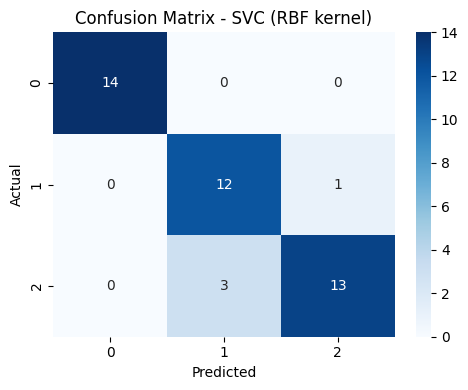

Linear SVM Accuracy: 0.9535
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.92      0.92      0.92        13
           2       0.94      0.94      0.94        16

    accuracy                           0.95        43
   macro avg       0.95      0.95      0.95        43
weighted avg       0.95      0.95      0.95        43



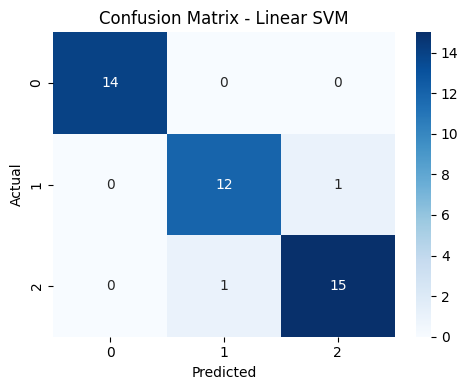

Polynomial SVM Accuracy: 0.8140
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.62      1.00      0.76        13
           2       1.00      0.50      0.67        16

    accuracy                           0.81        43
   macro avg       0.87      0.83      0.81        43
weighted avg       0.88      0.81      0.80        43



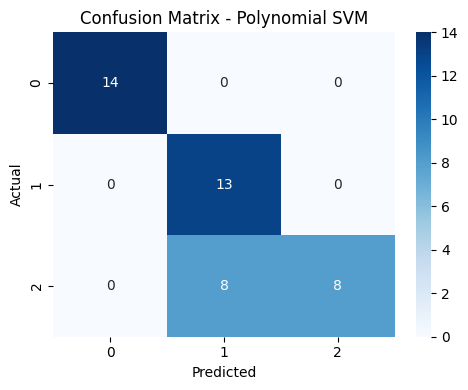

In [21]:
print("\nSVM Models:\n")
for name, model in svm_models.items():
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)
    print(f"{name} Accuracy: {accuracy_score(y_test_s, y_pred):.4f}")
    print(classification_report(y_test_s, y_pred))

# Confusion matrix
    cm = confusion_matrix(y_test_s, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()   

## Neural Network Implementation:
#### We trained two neural networks with different activation functions (ReLU and Sigmoid) for the hidden layer. It evaluates and prints the test accuracy, classification report, and confusion matrix for each model. It also plots the loss curves for both training and testing data.


Training Neural Network with activation: relu


D:\Programs\Pycharm\PythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Net (relu) Test Accuracy: 0.8372
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.75      0.69      0.72        13
           2       0.78      0.88      0.82        16

    accuracy                           0.84        43
   macro avg       0.84      0.83      0.84        43
weighted avg       0.84      0.84      0.84        43

Confusion Matrix:
 [[13  1  0]
 [ 0  9  4]
 [ 0  2 14]]


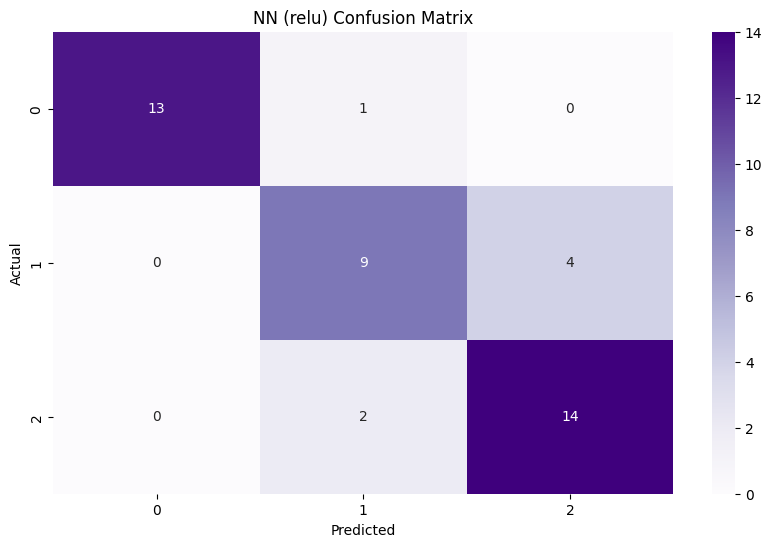

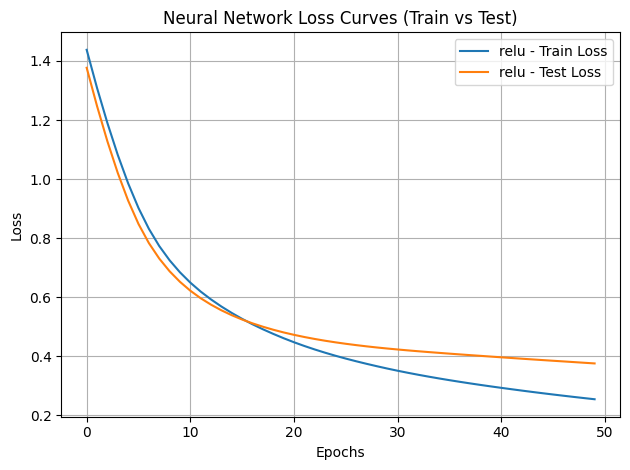


Training Neural Network with activation: sigmoid


D:\Programs\Pycharm\PythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Net (sigmoid) Test Accuracy: 0.8605
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.77      0.77      0.77        13
           2       0.81      0.81      0.81        16

    accuracy                           0.86        43
   macro avg       0.86      0.86      0.86        43
weighted avg       0.86      0.86      0.86        43

Confusion Matrix:
 [[14  0  0]
 [ 0 10  3]
 [ 0  3 13]]


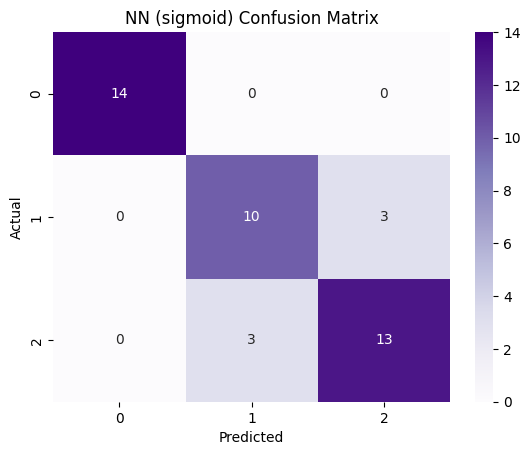

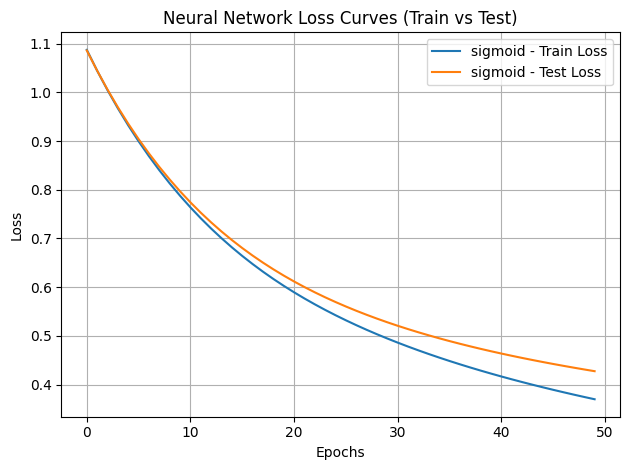

In [22]:
# Neural Network with Activation Function Loop
# 1. Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

activations = ['relu', 'sigmoid']

plt.figure(figsize=(10, 6))

for act in activations:
    print(f"\nTraining Neural Network with activation: {act}")
    
    model = Sequential()
    model.add(Dense(10, input_shape=(X_train_s.shape[1],), activation=act))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_s, y_train, validation_data=(X_test_s, y_test), 
                        epochs=50, batch_size=5, verbose=0)
    
    loss, accuracy = model.evaluate(X_test_s, y_test, verbose=0)
    print(f"Neural Net ({act}) Test Accuracy: {accuracy:.4f}")
    
    
    y_pred_nn = model.predict(X_test_s)
    y_pred_classes = np.argmax(y_pred_nn, axis=1)
    cm = confusion_matrix(y_test_s, y_pred_classes)
    print("Classification Report:\n", classification_report(y_test_s, y_pred_classes))
    print("Confusion Matrix:\n", cm)

    # Save confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f'NN ({act}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot loss
    plt.plot(history.history['loss'], label=f'{act} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'{act} - Test Loss')

    plt.title("Neural Network Loss Curves (Train vs Test)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Model Comparison and Analysis:
#### We selected the best-performing SVM model (Linear SVM) and the trained neural network for predictions. It then evaluates both models' performance using the classification report.

In [23]:
# Get best-performing SVM model (example: RBF)
svm_model = svm_models["Linear SVM"]
svm_preds = svm_model.predict(X_test_s)

# Get Neural Network predictions
nn_probs = model.predict(X_test_s)
nn_preds = np.argmax(nn_probs, axis=1)

# Convert one-hot y_test to integer for evaluation
y_test_int = np.argmax(y_test, axis=1)

# SVM Evaluation
print("=== SVM Performance ===")
print(classification_report(y_test_int, svm_preds))

# Neural Network Evaluation
print("=== Neural Network Performance ===")
print(classification_report(y_test_int, nn_preds))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
=== SVM Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.92      0.92      0.92        13
           2       0.94      0.94      0.94        16

    accuracy                           0.95        43
   macro avg       0.95      0.95      0.95        43
weighted avg       0.95      0.95      0.95        43

=== Neural Network Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.77      0.77      0.77        13
           2       0.81      0.81      0.81        16

    accuracy                           0.86        43
   macro avg       0.86      0.86      0.86        43
weighted avg       0.86      0.86      0.86        43



#### Finally, We compared ROC curves for a Linear SVM and a Neural Network by computing class-wise AUC scores, then plotted them together to visualize which model performs better across classes.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


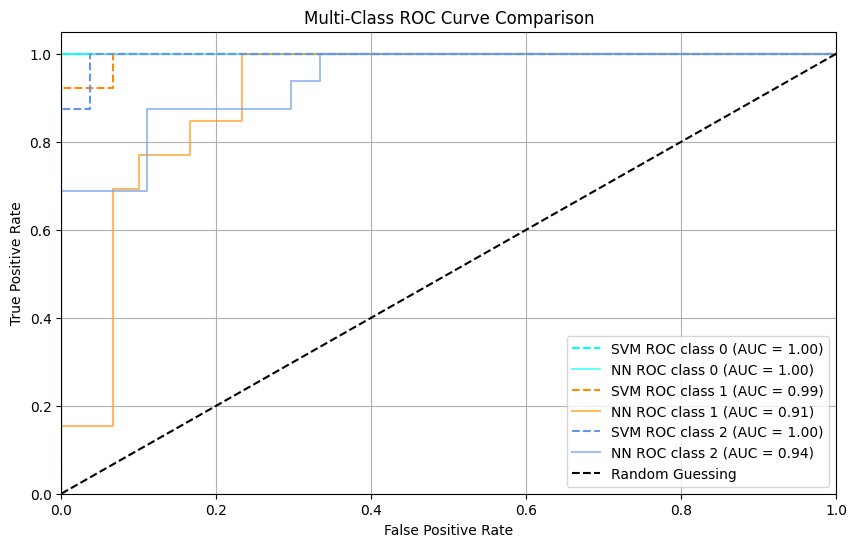

In [24]:
# Binarize the labels for multi-class ROC
classes = np.unique(y_test_int)
y_test_bin = label_binarize(y_test_int, classes=classes)
n_classes = y_test_bin.shape[1]

# SVM probability scores (using One-vs-Rest)
svm_model = svm_models["Linear SVM"]
svm_model_prob = SVC(kernel='linear', probability=True)
svm_model_prob.fit(X_train_s, y_train_s)
svm_probs = svm_model_prob.predict_proba(X_test_s)

# Neural Network probabilities
nn_probs = model.predict(X_test_s)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], svm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_nn = dict()
tpr_nn = dict()
roc_auc_nn = dict()

for i in range(n_classes):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(y_test_bin[:, i], nn_probs[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='--',
             label=f'SVM ROC class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot(fpr_nn[i], tpr_nn[i], color=color,
             label=f'NN ROC class {i} (AUC = {roc_auc_nn[i]:.2f})', alpha=0.6)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()